# Bayesian Optimization Demonstration
Here we demonstrate the process of BO using the package Botorch.

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
# define the ground truth function and the mesh we will plot over when doing
# visualization
def ground_truth(x):
    return torch.sin(2 * 3.14 * x / 1.0)

test_x = torch.linspace(0,1,100)


## Making GP Models
Here we define a function to generate a GP model given a set of training
inputs/outputs. For this demo we explicitly set the hyperparameters. In practice it
is better to train the hyperparameters by maximizing the likelihood via
`fit_gpytorch_mll`.

In [3]:
from botorch.models import SingleTaskGP

def create_model(train_x, train_y):
    model = SingleTaskGP(train_x, train_y)
    model.likelihood.noise = torch.tensor(1e-4)
    model.covar_module.base_kernel.lengthscale = torch.tensor(0.1)
    model.covar_module.outputscale = torch.tensor(0.05)

    return model


## Do optimization with visualization
Here we use Expected Improvement (EI) to optimize our function. The GP is initally
created with a single point. At each step we plot the current model, data and the
acquisition function value over the domain.

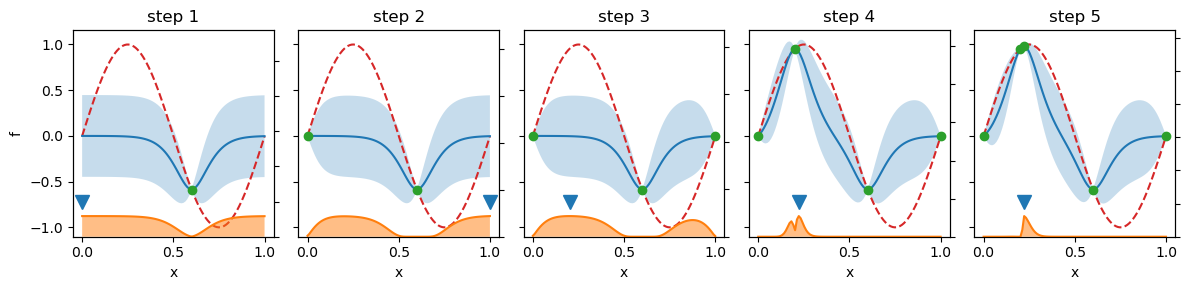

In [4]:
# do optimization loop with ucb
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

# create plotting axes
fig,ax = plt.subplots(1,5,sharex="all",sharey="all")
fig.set_size_inches(12,3)

# generate intial data
train_x = torch.tensor([0.6]).unsqueeze(-1)
train_y = ground_truth(train_x)

for i in range(5):
    # create model
    model = create_model(train_x, train_y)

    # create the acquisition function using the model
    acq = ExpectedImprovement(model, train_y.max())

    # optimize the acquisition function
    candidate,_ = optimize_acqf(
        acq,
        bounds=torch.tensor([0.0,1.0]).reshape(2,1),
        q=1,
        num_restarts=5,
        raw_samples=20
    )


    # get the model and acquisition function values over the domain for visualization
    # note the tensor shape passed to get the posterior and acquisition function value
    # torch.no_grad speeds up computation by not tracking gradients for backprop
    with torch.no_grad():
        # get the model posterior
        post = model.posterior(test_x.unsqueeze(-1))
        # get the model mean and confidence region
        mean = post.mean
        l,u = post.mvn.confidence_region()

        # get the acquisition function value
        acq_val = acq(test_x.reshape(-1,1,1))

    # plot the GP model, data and ground truth
    ax[i].plot(test_x, mean,label="posterior mean")
    ax[i].fill_between(test_x, l, u, alpha=0.25, label="confidence region")
    ax[i].plot(train_x, train_y, "oC2",zorder=10)
    ax[i].plot(test_x, ground_truth(test_x),'C3--',zorder=1)
    ax[i].set_title(f"step {i+1}")
    ax[i].set_xlabel(f"x")

    # plot the acquisition function
    ax2 = ax[i].twinx()
    ax2.plot(test_x, acq_val,"C1")
    ax2.fill_between(test_x, torch.zeros_like(acq_val), acq_val, alpha=0.5, fc="C1")
    ax2.set_yticklabels([])
    ax2.set_ylim(0, 10.0*acq_val.max())

    # plot the maximum point of the acquisition function
    ax2.plot(test_x[torch.argmax(acq_val)], acq_val[torch.argmax(acq_val)]*1.7,
         marker="v", ms=10)

    # add maximization point and resulting observation to training data
    train_x = torch.cat([train_x, candidate])
    train_y = ground_truth(train_x)
ax[0].set_ylabel("f")

fig.tight_layout()